You can read an overview of this Numerical Linear Algebra course in [this blog post](http://www.fast.ai/2017/07/17/num-lin-alg/).  The course was originally taught in the [University of San Francisco MS in Analytics](https://www.usfca.edu/arts-sciences/graduate-programs/analytics) graduate program.  Course lecture videos are [available on YouTube](https://www.youtube.com/playlist?list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY) (note that the notebook numbers and video numbers do not line up, since some notebooks took longer than 1 video to cover).

You can ask questions about the course on [our fast.ai forums](http://forums.fast.ai/c/lin-alg).

# 6. How to Implement Linear Regression

In the previous lesson, we calculated the least squares linear regression for a diabetes dataset, using scikit learn's implementation.  Today, we will look at how we could write our own implementation.

In [8]:
from sklearn import datasets, linear_model, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import math, scipy, numpy as np
from scipy import linalg

In [9]:
np.set_printoptions(precision=6)

In [10]:
data = datasets.load_diabetes()

In [11]:
feature_names=['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [12]:
trn,test,y_trn,y_test = train_test_split(data.data, data.target, test_size=0.2)

In [13]:
trn.shape, test.shape

((353, 10), (89, 10))

In [14]:
def regr_metrics(act, pred):
    return (math.sqrt(metrics.mean_squared_error(act, pred)), 
     metrics.mean_absolute_error(act, pred))

### How did sklearn do it?

How is sklearn doing this?  By checking [the source code](https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/linear_model/base.py#L417), you can see that in the dense case, it calls [scipy.linalg.lstqr](https://github.com/scipy/scipy/blob/v0.19.0/scipy/linalg/basic.py#L892-L1058), which is calling a LAPACK method:

        Options are ``'gelsd'``, ``'gelsy'``, ``'gelss'``. Default
        (``'gelsd'``) is a good choice.  However, ``'gelsy'`` can be slightly
        faster on many problems.  ``'gelss'`` was used historically.  It is
        generally slow but uses less memory.

- [gelsd](https://software.intel.com/sites/products/documentation/doclib/mkl_sa/11/mkl_lapack_examples/_gelsd.htm): uses SVD and a divide-and-conquer method
- [gelsy](https://software.intel.com/en-us/node/521113): uses QR factorization
- [gelss](https://software.intel.com/en-us/node/521114): uses SVD

#### Scipy Sparse Least Squares

We will not get into too much detail about the sparse version of least squares.  Here is a bit of info if you are interested: 

[Scipy sparse lsqr](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.lsqr.html#id1) uses an iterative method called [Golub and Kahan bidiagonalization](https://web.stanford.edu/class/cme324/paige-saunders2.pdf).

from [scipy sparse lsqr source code](https://github.com/scipy/scipy/blob/v0.14.0/scipy/sparse/linalg/isolve/lsqr.py#L96):
  Preconditioning is another way to reduce the number of iterations. If it is possible to solve a related system ``M*x = b`` efficiently, where M approximates A in some helpful way (e.g. M - A has low rank or its elements are small relative to those of A), LSQR may converge more rapidly on the system ``A*M(inverse)*z = b``, after which x can be recovered by solving M\*x = z.
  
If A is symmetric, LSQR should not be used! Alternatives are the symmetric conjugate-gradient method (cg) and/or SYMMLQ.  SYMMLQ is an implementation of symmetric cg that applies to any symmetric A and will converge more rapidly than LSQR.  If A is positive definite, there are other implementations of symmetric cg that require slightly less work per iteration than SYMMLQ (but will take the same number of iterations).

### linalg.lstqr

The sklearn implementation handled adding a constant term (since the y-intercept is presumably not 0 for the line we are learning) for us.  We will need to do that by hand now:

In [15]:
trn_int = np.c_[trn, np.ones(trn.shape[0])]
test_int = np.c_[test, np.ones(test.shape[0])]

Since `linalg.lstsq` lets us specify which LAPACK routine we want to use, lets try them all and do some timing comparisons:

In [16]:
%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelsd")

147 µs ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [17]:
%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelsy")

93.5 µs ± 6.24 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [18]:
%timeit coef, _,_,_ = linalg.lstsq(trn_int, y_trn, lapack_driver="gelss")

158 µs ± 6.22 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Naive Solution

Recall that we want to find $\hat{x}$ that minimizes: 
$$ \big\vert\big\vert Ax - b \big\vert\big\vert_2$$

Another way to think about this is that we are interested in where vector $b$ is closest to the subspace spanned by $A$ (called the *range of* $A$).  This is the projection of $b$ onto $A$.  Since $b - A\hat{x}$ must be perpendicular to the subspace spanned by $A$, we see that

$$A^T (b - A\hat{x}) = 0 $$

(we are using $A^T$ because we want to multiply each column of $A$ by $b - A\hat{x}$

This leads us to the *normal equations*:
$$ x = (A^TA)^{-1}A^T b $$

In [19]:
def ls_naive(A, b):
     return np.linalg.inv(A.T @ A) @ A.T @ b

In [20]:
%timeit coeffs_naive = ls_naive(trn_int, y_trn)

98.4 µs ± 4.17 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [21]:
coeffs_naive = ls_naive(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_naive)

(58.06404020242407, 48.40834205263381)

### Normal Equations (Cholesky)

Normal equations:
$$ A^TA x = A^T b $$

If $A$ has full rank, the pseudo-inverse $(A^TA)^{-1}A^T$ is a **square, hermitian positive definite** matrix.  The standard way of solving such a system is *Cholesky Factorization*, which finds upper-triangular R s.t. $A^TA = R^TR$.

The following steps are based on Algorithm 11.1 from Trefethen:

In [22]:
A = trn_int

In [23]:
b = y_trn

In [24]:
AtA = A.T @ A
Atb = A.T @ b

**Warning:** Numpy and Scipy default to different upper/lower for Cholesky

In [25]:
R = scipy.linalg.cholesky(AtA)

In [26]:
np.set_printoptions(suppress=True, precision=4)
R

array([[ 0.8914,  0.1547,  0.1984,  0.3034,  0.2353,  0.2059, -0.0775,
         0.1938,  0.2504,  0.2505, -0.5416],
       [ 0.    ,  0.8784,  0.0733,  0.1531,  0.0109,  0.1074, -0.3499,
         0.2953,  0.129 ,  0.1451, -0.4818],
       [ 0.    ,  0.    ,  0.888 ,  0.2712,  0.1644,  0.1841, -0.3349,
         0.3442,  0.3512,  0.2825, -0.4115],
       [ 0.    ,  0.    ,  0.    ,  0.7706,  0.0797,  0.0185,  0.0127,
         0.0127,  0.1583,  0.1516, -0.2525],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.8279,  0.7636,  0.1295,
         0.3929,  0.3026,  0.1692, -0.9911],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.3761, -0.4396,
         0.2865, -0.3083, -0.0324,  0.0835],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.6269,
        -0.4773, -0.5256, -0.1473,  0.6122],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
         0.3032, -0.022 ,  0.0646,  0.2459],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
 

check our factorization:

In [27]:
np.linalg.norm(AtA - R.T @ R)

5.684568971078027e-14

$$ A^T A x = A^T b $$
$$ R^T R x = A^T b $$
$$ R^T w = A^T b $$
$$ R x = w $$

In [28]:
w = scipy.linalg.solve_triangular(R, Atb, lower=False, trans='T')

It's always good to check that our result is what we expect it to be: (in case we entered the wrong params, the function didn't return what we thought, or sometimes the docs are even outdated)

In [29]:
np.linalg.norm(R.T @ w - Atb)

7.27622481090267e-12

In [30]:
coeffs_chol = scipy.linalg.solve_triangular(R, w, lower=False)

In [31]:
np.linalg.norm(R @ coeffs_chol - w)

1.3342793151745925e-13

In [32]:
def ls_chol(A, b):
    R = scipy.linalg.cholesky(A.T @ A)
    w = scipy.linalg.solve_triangular(R, A.T @ b, trans='T')
    return scipy.linalg.solve_triangular(R, w)

In [33]:
%timeit coeffs_chol = ls_chol(trn_int, y_trn)

62.6 µs ± 4.18 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [34]:
coeffs_chol = ls_chol(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_chol)

(58.06404020242421, 48.408342052633884)

### QR Factorization

$$ A x = b $$
$$ A = Q R $$
$$ Q R x = b $$

$$ R x = Q^T b $$

In [35]:
def ls_qr(A,b):
    Q, R = scipy.linalg.qr(A, mode='economic')
    return scipy.linalg.solve_triangular(R, Q.T @ b)

In [36]:
%timeit coeffs_qr = ls_qr(trn_int, y_trn)

128 µs ± 10.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
coeffs_qr = ls_qr(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_qr)

(58.06404020242421, 48.408342052633905)

### SVD

$$ A x = b $$

$$ A = U \Sigma V $$

$$ \Sigma V x = U^T b $$

$$ \Sigma w = U^T b $$

$$ x = V^T w $$

SVD gives the pseudo-inverse

In [38]:
def ls_svd(A,b):
    m, n = A.shape
    U, sigma, Vh = scipy.linalg.svd(A, full_matrices=False, lapack_driver='gesdd')
    w = (U.T @ b)/ sigma
    return Vh.T @ w

In [39]:
%timeit coeffs_svd = ls_svd(trn_int, y_trn)

136 µs ± 4.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [254]:
%timeit coeffs_svd = ls_svd(trn_int, y_trn)

266 µs ± 8.49 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [40]:
coeffs_svd = ls_svd(trn_int, y_trn)
regr_metrics(y_test, test_int @ coeffs_svd)

(58.06404020242444, 48.40834205263408)

### Random Sketching Technique for Least Squares Regression

[Linear Sketching](http://researcher.watson.ibm.com/researcher/files/us-dpwoodru/journal.pdf) (Woodruff)

1. Sample a r x n random matrix S, r << n
2. Compute S A and S b
3. Find exact solution x to regression SA x = Sb

### Timing Comparison

In [41]:
import timeit
import pandas as pd

In [42]:
def scipylstq(A, b):
    return scipy.linalg.lstsq(A,b)[0]

In [43]:
row_names = ['Normal Eqns- Naive',
             'Normal Eqns- Cholesky', 
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'Normal Eqns- Cholesky': 'ls_chol', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [44]:
m_array = np.array([100, 1000, 10000])
n_array = np.array([20, 100, 1000])

In [45]:
index = pd.MultiIndex.from_product([m_array, n_array], names=['# rows', '# cols'])

In [55]:
pd.options.display.float_format = '{:,.6f}'.format
df = pd.DataFrame(index=row_names, columns=index)
df_error = pd.DataFrame(index=row_names, columns=index)

In [58]:
df

# rows                100             1000            10000          
# cols                 20   100  1000  20   100  1000  20   100  1000
Normal Eqns- Naive      NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  NaN
Normal Eqns- Cholesky   NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  NaN
QR Factorization        NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  NaN
SVD                     NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  NaN
Scipy lstsq             NaN  NaN  NaN   NaN  NaN  NaN   NaN  NaN  NaN

In [59]:
%%prun
for m in m_array:
    for n in n_array:
        if m >= n:        
            x = np.random.uniform(-10,10,n)
            A = np.random.uniform(-40,40,[m,n])   # removed np.asfortranarray
            b = np.matmul(A, x) + np.random.normal(0,2,m)
            for name in row_names:
                fcn = name2func[name]
                t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
                df.set_value(name, (m,n), t)
                coeffs = locals()[fcn](A, b)
                reg_met = regr_metrics(b, A @ coeffs)
                df_error.set_value(name, (m,n), reg_met[0])

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: s

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: s

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


In [49]:
df

# rows                   100                    1000                     \
# cols                    20       100  1000     20       100      1000   
Normal Eqns- Naive    0.002193 0.015624  NaN 0.005138 0.025881 0.433244   
Normal Eqns- Cholesky 0.000489 0.002171  NaN 0.002363 0.003916 0.137040   
QR Factorization      0.001025 0.010370  NaN 0.004253 0.012179 0.307910   
SVD                   0.001617 0.012094  NaN 0.003583 0.020038 1.247264   
Scipy lstsq           0.001555 0.008790  NaN 0.002527 0.016042 1.263869   

# rows                   10000                    
# cols                    20       100      1000  
Normal Eqns- Naive    0.008664 0.104528 2.029226  
Normal Eqns- Cholesky 0.003174 0.045108 0.625336  
QR Factorization      0.021309 0.236172 3.206565  
SVD                   0.019615 0.235451 4.689358  
Scipy lstsq           0.013802 0.160826 2.613864

In [50]:
df_error

# rows                   100                    1000                     \
# cols                    20       100  1000     20       100      1000   
Normal Eqns- Naive    1.967508 0.000000  NaN 1.973750 1.893081 0.000001   
Normal Eqns- Cholesky 1.967508 0.000000  NaN 1.973750 1.893081 0.000000   
QR Factorization      1.967508 0.000000  NaN 1.973750 1.893081 0.000000   
SVD                   1.967508 0.000000  NaN 1.973750 1.893081 0.000000   
Scipy lstsq           1.967508 0.000000  NaN 1.973750 1.893081 0.000000   

# rows                   10000                    
# cols                    20       100      1000  
Normal Eqns- Naive    1.990631 2.005019 1.900270  
Normal Eqns- Cholesky 1.990631 2.005019 1.900270  
QR Factorization      1.990631 2.005019 1.900270  
SVD                   1.990631 2.005019 1.900270  
Scipy lstsq           1.990631 2.005019 1.900270

In [51]:
store = pd.HDFStore('least_squares_results.h5')

In [52]:
store['df'] = df

C:\Users\Dell\Anaconda3\lib\site-packages\tables\attributeset.py:464: NaturalNameWarning: object name is not a valid Python identifier: 'axis0_name# rows'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\Dell\Anaconda3\lib\site-packages\tables\attributeset.py:464: NaturalNameWarning: object name is not a valid Python identifier: 'axis0_name# cols'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
C:\Users\Dell\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3319: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block0_values] [items->[(100, 20), (100, 100), (100, 1

In [54]:
store

<class 'pandas.io.pytables.HDFStore'>
File path: least_squares_results.h5

## Notes

I used the magick %prun to profile my code.

Alternative: least absolute deviation (L1 regression)
- Less sensitive to outliers than least squares.
- No closed form solution, but can solve with linear programming

## Conditioning & stability

#### Condition Number

*Condition number* is a measure of how small changes to the input cause the output to change.

**Question**: Why do we care about behavior with small changes to the input in numerical linear algebra?

The *relative condition number* is defined by

$$ \kappa = \sup_{\delta x} \frac{\|\delta f\|}{\| f(x) \|}\bigg/ \frac{\| \delta x \|}{\| x \|} $$
  
where $\delta x$ is infinitesimal

According to Trefethen (pg. 91), a problem is *well-conditioned* if $\kappa$ is small (e.g. $1$, $10$, $10^2$) and *ill-conditioned* if $\kappa$ is large (e.g. $10^6$, $10^{16}$)

**Conditioning**: perturbation behavior of a mathematical problem (e.g. least squares)

**Stability**: perturbation behavior of an algorithm used to solve that problem on a computer (e.g. least squares algorithms, householder, back substitution, gaussian elimination)

#### Conditioning example

The problem of computing eigenvalues of a non-symmetric matrix is often ill-conditioned

In [60]:
A = [[1, 1000], [0, 1]]
B = [[1, 1000], [0.001, 1]]

In [61]:
wA, vrA = scipy.linalg.eig(A)
wB, vrB = scipy.linalg.eig(B)

In [62]:
wA, wB

(array([1.+0.j, 1.+0.j]), array([2.+0.j, 0.+0.j]))

#### Condition Number of a Matrix

The product $\| A\| \|A^{-1} \|$ comes up so often it has its own name: the *condition number* of $A$.  Note that normally we talk about the conditioning of problems, not matrices.

The *condition number* of $A$ relates to:
- computing $b$ given $A$ and $x$ in $Ax = b$
- computing $x$ given $A$ and $b$ in $Ax = b$

## Loose ends from last time

### Full vs Reduced Factorizations

**SVD**

Diagrams from Trefethen:

<img src="images/full_svd.JPG" alt="" style="width: 80%"/>

<img src="images/reduced_svd.JPG" alt="" style="width: 70%"/>

**QR Factorization exists for ALL matrices**

Just like with SVD, there are full and reduced versions of the QR factorization.

<img src="images/full_qr.JPG" alt="" style="width: 70%"/>

<img src="images/reduced_qr.JPG" alt="" style="width: 70%"/>

### Matrix Inversion is Unstable

In [1]:
from scipy.linalg import hilbert

In [2]:
n = 14
A = hilbert(n)
x = np.random.uniform(-10,10,n)
b = A @ x

In [7]:
A_inv = np.linalg.inv(A)

In [8]:
np.linalg.norm(np.eye(n) - A @ A_inv)

4.614466857708301

In [9]:
np.linalg.cond(A)

9.274324459181185e+17

In [10]:
A @ A_inv

array([[ 9.99999995e-01,  2.01303081e-07,  4.00892117e-06,
         3.03305275e-04, -7.75317064e-04, -3.33037464e-03,
         6.81050598e-03, -5.86746411e-02, -2.35782141e-02,
         3.12500000e-01,  8.79427665e-02, -1.48395821e-01,
         6.49086773e-03, -5.68644002e-02],
       [-1.82556125e-08,  1.00000250e+00, -7.47227475e-05,
         1.44813126e-03, -1.25995271e-02,  7.84546834e-02,
        -1.67421299e-01,  2.11309250e-01, -2.76334917e-01,
         6.25000000e-01, -9.45105021e-01, -1.36709025e-01,
        -1.61046420e-03, -1.01433600e-02],
       [ 4.65661287e-10, -2.98023224e-07,  1.00000954e+00,
        -2.13623047e-04,  1.95312500e-03,  1.95312500e-03,
         1.56250000e-02, -1.56250000e-02,  3.12500000e-01,
         1.25000000e-01, -2.81250000e-01, -3.12500000e-02,
         0.00000000e+00, -1.26953125e-02],
       [ 1.06679056e-09,  6.49762744e-07,  8.79135159e-06,
         9.99945760e-01,  4.68010476e-03, -4.07247279e-02,
         8.94076777e-02, -6.30646250e-01,  9.

In [11]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [238]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [239]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.set_value(name, 'Time', t)
    df.set_value(name, 'Error', regr_metrics(b, A @ coeffs)[0])

#### SVD is best here!

DO NOT RERUN

In [240]:
df

,Time,Error
Normal Eqns- Naive,0.001334339,3.598901966
QR Factorization,0.002166139,0.000000000
SVD,0.001556937,0.000000000
Scipy lstsq,0.001871590,0.000000000


In [240]:
df

,Time,Error
Normal Eqns- Naive,0.001334339,3.598901966
QR Factorization,0.002166139,0.000000000
SVD,0.001556937,0.000000000
Scipy lstsq,0.001871590,0.000000000


**Another reason not to take inverse**

Even if $A$ is incredibly sparse, $A^{-1}$ is generally dense.  For large matrices, $A^{-1}$ could be so dense as to not fit in memory.

## Runtime

Matrix Inversion: $2n^3$

Matrix Multiplication: $n^3$

Cholesky: $\frac{1}{3}n^3$

QR, Gram Schmidt: $2mn^2$, $m\geq n$ (chapter 8 of Trefethen)

QR, Householder: $2mn^2 - \frac{2}{3}n^3$ (chapter 10 of Trefethen)

Solving a triangular system: $n^2$

**Why Cholesky Factorization is Fast:**

<img src="images/cholesky_factorization_speed.png" alt="" style="width: 100%"/>
(source: [Stanford Convex Optimization: Numerical Linear Algebra Background Slides](http://stanford.edu/class/ee364a/lectures/num-lin-alg.pdf))

### A Case Where QR is the Best

In [12]:
m=100
n=15
t=np.linspace(0, 1, m)

In [13]:
# Vandermonde matrix
A=np.stack([t**i for i in range(n)], 1)

In [67]:
b=np.exp(np.sin(4*t))

# This will turn out to normalize the solution to be 1
b /= 2006.787453080206

In [68]:
from matplotlib import pyplot as plt
%matplotlib inline

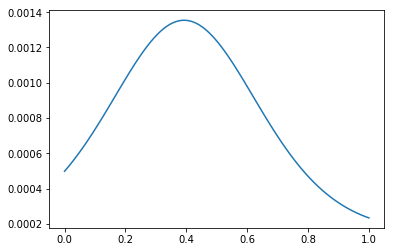

In [69]:
plt.plot(t, b)

Check that we get 1:

In [58]:
1 - ls_qr(A, b)[14]

1.4137685733217609e-07

Bad condition number:

In [60]:
kappa = np.linalg.cond(A); kappa

5.827807196683593e+17

In [181]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [74]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [75]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.set_value(name, 'Time', t)
    df.set_value(name, 'Error', np.abs(1 - coeffs[-1]))

In [76]:
df

,Time,Error
Normal Eqns- Naive,0.001565099,1.357066025
QR Factorization,0.002632104,0.000000116
SVD,0.003503785,0.000000116
Scipy lstsq,0.002763502,0.000000116



The solution for least squares via the normal equations is unstable in general, although stable for problems with small condition numbers.

### Low-rank

In [258]:
m = 100
n = 10
x = np.random.uniform(-10,10,n)
A2 = np.random.uniform(-40,40, [m, int(n/2)])   # removed np.asfortranarray
A = np.hstack([A2, A2])

In [259]:
A.shape, A2.shape

((100, 10), (100, 5))

In [260]:
b = A @ x + np.random.normal(0,1,m)

In [263]:
row_names = ['Normal Eqns- Naive',
             'QR Factorization', 
             'SVD', 
             'Scipy lstsq']

name2func = {'Normal Eqns- Naive': 'ls_naive', 
             'QR Factorization': 'ls_qr',
             'SVD': 'ls_svd',
             'Scipy lstsq': 'scipylstq'}

In [264]:
pd.options.display.float_format = '{:,.9f}'.format
df = pd.DataFrame(index=row_names, columns=['Time', 'Error'])

In [265]:
for name in row_names:
    fcn = name2func[name]
    t = timeit.timeit(fcn + '(A,b)', number=5, globals=globals())
    coeffs = locals()[fcn](A, b)
    df.set_value(name, 'Time', t)
    df.set_value(name, 'Error', regr_metrics(b, A @ coeffs)[0])

In [266]:
df

,Time,Error
Normal Eqns- Naive,0.001227640,300.658979382
QR Factorization,0.002315920,0.876019803
SVD,0.001745647,1.584746056
Scipy lstsq,0.002067989,0.804750398


## Comparison

Our results from above:

In [257]:
df

# rows                   100                    1000                     \
# cols                    20       100  1000     20       100      1000   
Normal Eqns- Naive    0.001276 0.003634  NaN 0.000960 0.005172 0.293126   
Normal Eqns- Cholesky 0.001660 0.003958  NaN 0.001665 0.004007 0.093696   
QR Factorization      0.002174 0.006486  NaN 0.004235 0.017773 0.213232   
SVD                   0.003880 0.021737  NaN 0.004672 0.026950 1.280490   
Scipy lstsq           0.004338 0.020198  NaN 0.004320 0.021199 1.083804   

# rows                   10000                    
# cols                    20       100      1000  
Normal Eqns- Naive    0.002226 0.021248 1.164655  
Normal Eqns- Cholesky 0.001928 0.010456 0.399464  
QR Factorization      0.019229 0.116122 2.208129  
SVD                   0.018138 0.130652 3.433003  
Scipy lstsq           0.012200 0.088467 2.134780

From Trefethen (page 84):

Normal equations/Cholesky is fastest when it works.  Cholesky can only be used on symmetric, positive definite matrices.  Also, normal equations/Cholesky is unstable for matrices with high condition numbers or with low-rank.

Linear regression via QR has been recommended by numerical analysts as the standard method for years.  It is natural, elegant, and good for "daily use".